# Data Modelling and Analysis Project - Household Consumption of Electricity and Gas. Egor Pereviazkin

# Preparation

## Loading the libraries

In [1256]:
import numpy as np
import pandas as pd
import sqlite3

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split

from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set_theme()
plt.rcParams['figure.figsize'] = 16, 9  # default hor./vert. size of plots, in inches

## Loading the data

In [ ]:
household_1 = "Customer 8"
household_2 = "Customer 43"

conn_customer = sqlite3.connect('GA2_files/data.db')

query_customer = """
    SELECT * 
    FROM customer
    WHERE customer LIKE "Customer 8" OR customer LIKE "Customer 43"
"""

df_customer = pd.read_sql_query(query_customer, conn_customer, index_col='customer')
df_customer.head()

,house_type,build_era,household_type
customer,,,
Customer 8,None,None,None
Customer 43,Semi-detached house,1940 - 1979,Single


In [ ]:
query_household_1 = f"""
    SELECT gas.datetime, gas.date, gas."{household_1}" AS "gas", electricity."{household_1}" AS "electricity", weather.temperature, weather.wind_speed
    FROM gas, electricity, weather
    WHERE gas.datetime=electricity.datetime AND gas.datetime=weather.datetime AND gas.date LIKE "2013%"
"""

df_household_1 = pd.read_sql_query(query_household_1, conn_customer, parse_dates=['datetime', 'date'], index_col='datetime')
df_household_1.head(50000)


,date,gas,electricity,temperature,wind_speed
datetime,,,,,
2013-01-01 01:00:00,2013-01-01,0.293928,744.0,8.6,8.0
2013-01-01 02:00:00,2013-01-01,0.269638,688.0,8.5,6.0
2013-01-01 03:00:00,2013-01-01,0.040605,486.0,8.6,5.0
2013-01-01 04:00:00,2013-01-01,0.001121,353.0,8.6,6.0
2013-01-01 05:00:00,2013-01-01,0.000000,348.0,8.6,4.0
...,...,...,...,...,...
2013-12-31 20:00:00,2013-12-31,0.120527,1193.0,6.6,6.0
2013-12-31 21:00:00,2013-12-31,0.081348,1670.0,6.1,4.0
2013-12-31 22:00:00,2013-12-31,0.019233,769.0,5.9,5.0


In [ ]:


query_household_2 = f"""
    SELECT gas.datetime, gas.date, gas."{household_2}" AS "gas", electricity."{household_2}" AS "electricity", weather.temperature, weather.wind_speed
    FROM gas, electricity, weather
    WHERE gas.datetime=electricity.datetime AND gas.datetime=weather.datetime AND gas.date LIKE "2013%"
"""

df_household_2 = pd.read_sql_query(query_household_2, conn_customer, parse_dates=['datetime', 'date'], index_col='datetime')
df_household_2.head(50000)


,date,gas,electricity,temperature,wind_speed
datetime,,,,,
2013-01-01 01:00:00,2013-01-01,0.000000,127.0,8.6,8.0
2013-01-01 02:00:00,2013-01-01,0.000000,131.0,8.5,6.0
2013-01-01 03:00:00,2013-01-01,0.000000,130.0,8.6,5.0
2013-01-01 04:00:00,2013-01-01,0.000000,130.0,8.6,6.0
2013-01-01 05:00:00,2013-01-01,0.000000,129.0,8.6,4.0
...,...,...,...,...,...
2013-12-31 20:00:00,2013-12-31,0.586450,374.0,6.6,6.0
2013-12-31 21:00:00,2013-12-31,0.443943,375.0,6.1,4.0
2013-12-31 22:00:00,2013-12-31,0.231294,377.0,5.9,5.0


# Data quality

In [ ]:


df_household_1['missing'] = df_household_1.isnull().any(axis=1)
household_1_missing_percent = df_household_1["missing"].mean()*100
print(household_1_missing_percent)

df_household_2['missing'] = df_household_2.isnull().any(axis=1)
household_2_missing_percent = df_household_2["missing"].sum()/df_household_2["missing"].count()*100
print(household_2_missing_percent)

df_household_1[df_household_1['missing']==True]

0.03424657534246575
0.03424657534246575


,date,gas,electricity,temperature,wind_speed,missing
datetime,,,,,,
2013-10-27 01:00:00,2013-10-27,NaN,203.0,15.0,5.0,True
2013-10-27 02:00:00,2013-10-27,NaN,201.0,14.7,6.0,True
2014-01-01 00:00:00,2013-12-31,NaN,NaN,6.0,5.0,True


In [ ]:


s_missing_household_1 = df_household_1.groupby("date")["missing"].mean().multiply(100)
s_missing_household_1.head()

s_missing_household_2 = df_household_2.groupby("date")["missing"].mean().multiply(100)
s_missing_household_2.head()

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
Name: missing, dtype: float64

In [ ]:


observations_missing_data = """
    There are only 3 hours with missing values for both households. 2 hours with missing values were on 2013-10-27 and third hour was on 
    2013-12-31. So, we can say that the data is clustered. Since there are only 3 rows with missing values out of 8760, we can 
    remove all of them, and it will help to avoid unwanted effects on data analysis, incorrect conclusions and issues with carrying t-tests.
"""


# Taking a first look at the data

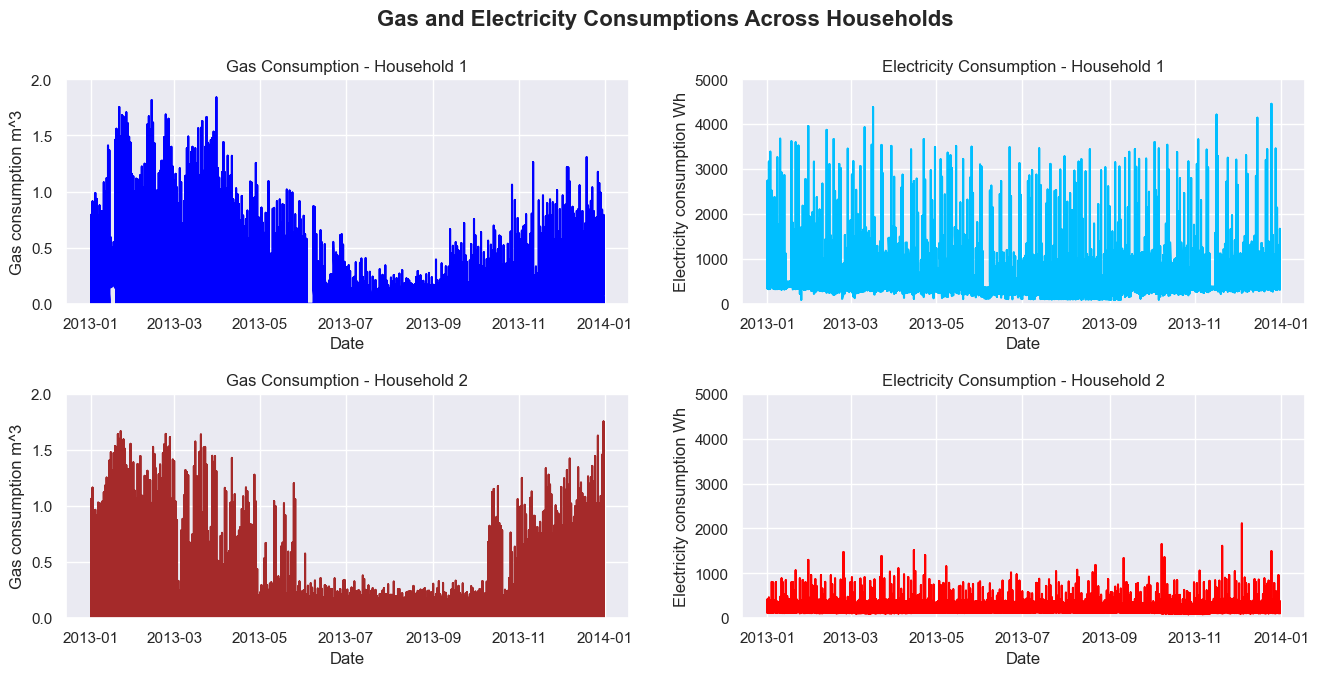

In [ ]:

fig, ax = plt.subplots(2, 2, figsize=(16,7))
ax[0, 0].plot(df_household_1['date'], df_household_1['gas'], label='Gas Consumption (Household 1)', color='blue')
ax[0, 0].set_title('Gas Consumption - Household 1')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Gas consumption m^3')
ax[0, 0].set_ylim(0, 2)

ax[1, 0].plot(df_household_2['date'], df_household_2['gas'], label='Gas Consumption (Household 2)', color='brown')
ax[1, 0].set_title('Gas Consumption - Household 2')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Gas consumption m^3')
ax[1, 0].set_ylim(0, 2)

ax[0, 1].plot(df_household_1['date'], df_household_1['electricity'], label='Electricity Consumption (Household 1)', color='deepskyblue')
ax[0, 1].set_title('Electricity Consumption - Household 1')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Electricity consumption Wh')
ax[0, 1].set_ylim(0, 5000)

ax[1, 1].plot(df_household_2['date'], df_household_2['electricity'], label='Electricity Consumption (Household 2)', color='red')
ax[1, 1].set_title('Electricity Consumption - Household 2')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Electricity consumption Wh')
ax[1, 1].set_ylim(0, 5000)

plt.suptitle('Gas and Electricity Consumptions Across Households', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.2)

observations_figure_1 = """ 
        While both households show pretty logical pattern of gas consumtion: high consumption in winter and low consumption in summer, 
        household 1 shows greater consumption throughout the period of investigation. However, there is a significant difference in the 
        electricity consumption between households: while household 1 consistenly has higher electricity usage values, ranging between
        1000 Wh and 4500 Wh, household 2 generally exhibits much lower electricity consumption, mostly staying below 1500 Wh.
"""

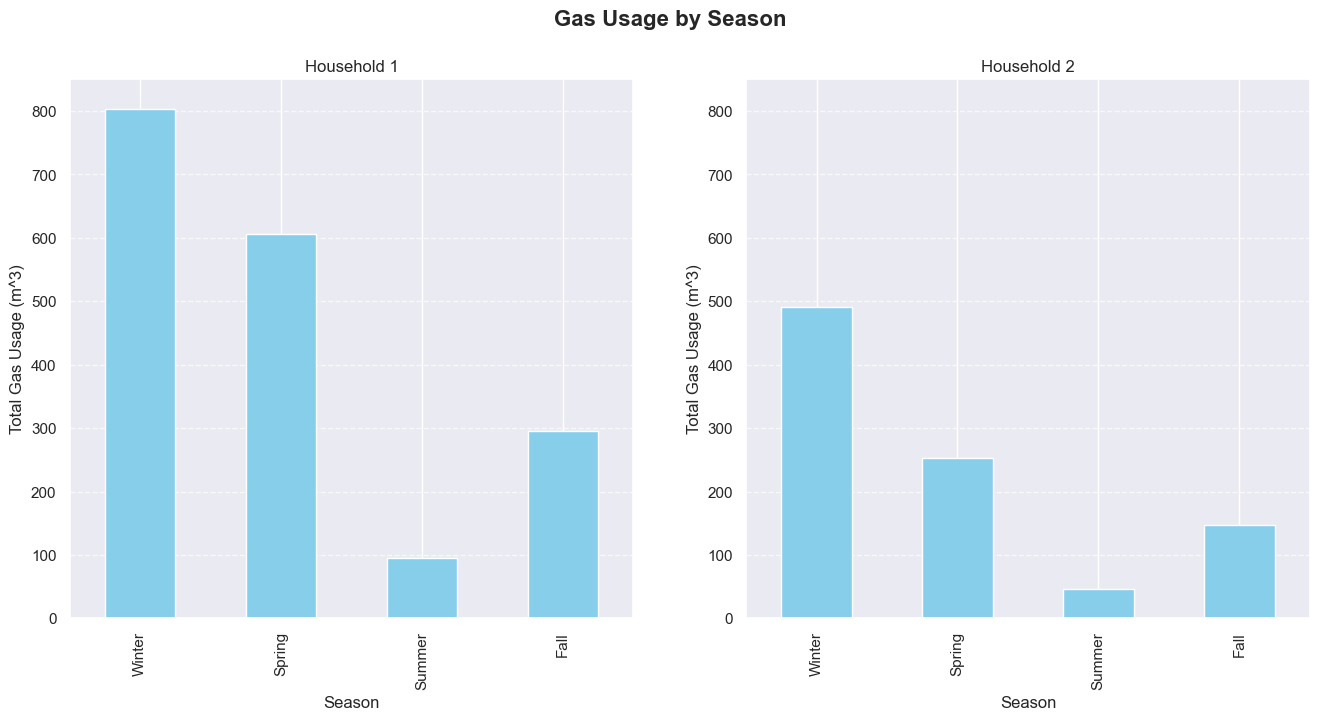

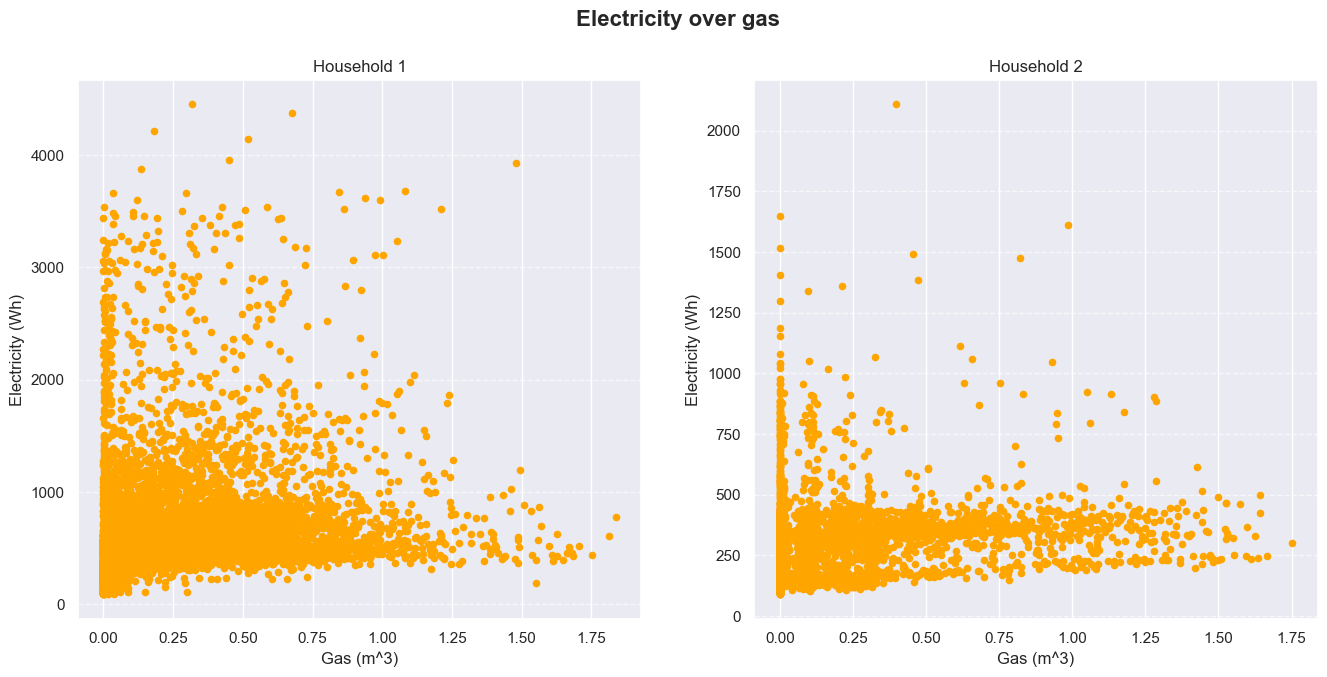

In [ ]:


df_household_1['date'] = pd.to_datetime(df_household_1['date'])
df_household_2['date'] = pd.to_datetime(df_household_2['date'])

def get_season(date):
    if date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df_household_1['season'] = df_household_1['date'].apply(get_season)
seasonal_gas_1 = df_household_1.groupby('season')['gas'].sum()
seasonal_gas_1 = seasonal_gas_1.loc[['Winter', 'Spring', 'Summer', 'Fall']]

df_household_2['season'] = df_household_2['date'].apply(get_season)
seasonal_gas_2 = df_household_2.groupby('season')['gas'].sum()
seasonal_gas_2 = seasonal_gas_2.loc[['Winter', 'Spring', 'Summer', 'Fall']]

observations_figure_2 = """
    Both households show logical pattern of gas consumption per season: high consumption in winter, low consumption in summer, 
    moderate usage in spring and fall, with lower gas consumption in fall.
    However, household 1 shows greater gas consumption throughout the period of investigation.
"""

fig, ax = plt.subplots(1, 2, figsize=(16,7))
seasonal_gas_1.plot(kind='bar', color='skyblue', ax=ax[0])
seasonal_gas_2.plot(kind='bar', color='skyblue', ax=ax[1])

ax[0].set_xlabel('Season')
ax[0].set_ylabel('Total Gas Usage (m^3)')
ax[0].set_title('Household 1')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].set_ylim(0, 850)
plt.suptitle('Gas Usage by Season', fontweight='bold', fontsize=16)

ax[1].set_xlabel('Season')
ax[1].set_ylabel('Total Gas Usage (m^3)')
ax[1].set_title('Household 2')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_ylim(0, 850)

fig, ax = plt.subplots(1, 2, figsize=(16,7))
df_household_1.plot(kind='scatter', x='gas', y='electricity', color='orange', ax=ax[0])
df_household_2.plot(kind='scatter', x='gas', y='electricity', color='orange', ax=ax[1])

ax[0].set_xlabel('Gas (m^3)')
ax[0].set_ylabel('Electricity (Wh)')
ax[0].set_title('Household 1')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)


ax[1].set_xlabel('Gas (m^3)')
ax[1].set_ylabel('Electricity (Wh)')
ax[1].set_title('Household 2')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.suptitle('Electricity over gas', fontweight='bold', fontsize=16)

observations_figure_3 = """
    As was observed in orevious question, household 1 consistenly has higher electricity consumption values, ranging between 1000 Wh and 
    4500 Wh, household 2 generally exhibits much lower electricity consumption, mostly staying below 1500 Wh. This might happen due to 
    different energy needs or appliance usage compared to Household 2. Higher gas usage does not significantly correspond to lower 
    electricity consumption or vice versa. This might indicate that gas and electricity serve different purposes (for example, gas for 
    heating, electricity for appliances).
"""

# Problem statement

In [ ]:
problem_statement = """
    Do weather conditions, different from temperature and wind speed, affect energy consumption?
"""


In [ ]:


hypothesis = """
    Electricity consumption is greater during hours with significant cloud cover.
"""


In [ ]:


refined_hypothesis = """
    The average electricity consumption in 2013 was higher during hours with a cloud cover of 5 octants or more compared to hours with 
    less than 5 octants of cloud cover.
"""

# Identify atypical periods

In [ ]:


df_household_1['date'] = pd.to_datetime(df_household_1['date'])
df_household_2['date'] = pd.to_datetime(df_household_2['date'])

df_household_1_filt = df_household_1.dropna(subset=('electricity', 'gas'))
df_daily_peak_household_1 = df_household_1_filt.groupby('date').agg({'gas': 'max', 'electricity': 'max'})
df_household_2_filt = df_household_2.dropna(subset=('electricity', 'gas'))
df_daily_peak_household_2 = df_household_2_filt.groupby('date').agg({'gas': 'max', 'electricity': 'max'})

daily_filter_missing_reasoning = """
Remove all rows with missing values since there are only 3 such rows. Deleting these rows helps to avoid unwanted effects on data analysis, 
incorrect conclusions and issues with carrying t-tests
"""

df_daily_peak_household_1, df_daily_peak_household_2

(                 gas  electricity
 date                             
 2013-01-01  0.792884       2741.0
 2013-01-02  0.912409       3167.0
 2013-01-03  0.810022       3387.0
 2013-01-04  0.986382       2520.0
 2013-01-05  0.934336       2067.0
 ...              ...          ...
 2013-12-27  1.175236       1094.0
 2013-12-28  1.075227       3457.0
 2013-12-29  0.989370       2141.0
 2013-12-30  0.838461       1311.0
 2013-12-31  0.791943       1670.0
 
 [365 rows x 2 columns],
                  gas  electricity
 date                             
 2013-01-01  1.063320        421.0
 2013-01-02  1.163270        461.0
 2013-01-03  0.935917        402.0
 2013-01-04  0.965285        808.0
 2013-01-05  0.916298        796.0
 ...              ...          ...
 2013-12-27  1.625879        782.0
 2013-12-28  1.025100        605.0
 2013-12-29  1.088858        545.0
 2013-12-30  1.456358        960.0
 2013-12-31  1.752201        377.0
 
 [365 rows x 2 columns])

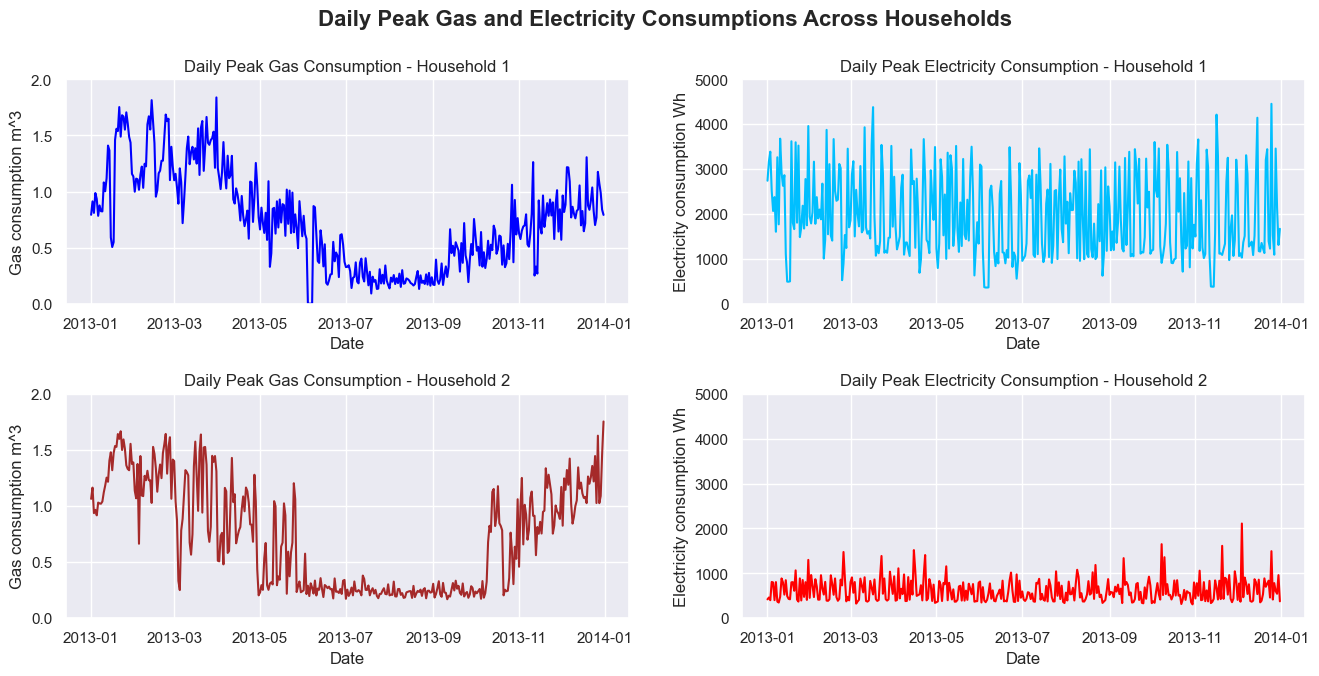

In [ ]:


fig, ax = plt.subplots(2, 2, figsize=(16,7))
ax[0, 0].plot(df_daily_peak_household_1.index, df_daily_peak_household_1['gas'], label='Gas Consumption (Household 1)', color='blue')
ax[0, 0].set_title('Daily Peak Gas Consumption - Household 1')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Gas consumption m^3')
ax[0, 0].set_ylim(0, 2)

ax[1, 0].plot(df_daily_peak_household_2.index, df_daily_peak_household_2['gas'], label='Gas Consumption (Household 2)', color='brown')
ax[1, 0].set_title('Daily Peak Gas Consumption - Household 2')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Gas consumption m^3')
ax[1, 0].set_ylim(0, 2)

ax[0, 1].plot(df_daily_peak_household_1.index, df_daily_peak_household_1['electricity'], label='Electricity Consumption (Household 1)', color='deepskyblue')
ax[0, 1].set_title('Daily Peak Electricity Consumption - Household 1')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Electricity consumption Wh')
ax[0, 1].set_ylim(0, 5000)

ax[1, 1].plot(df_daily_peak_household_2.index, df_daily_peak_household_2['electricity'], label='Electricity Consumption (Household 2)', color='red')
ax[1, 1].set_title('Daily Peak Electricity Consumption - Household 2')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Electricity consumption Wh')
ax[1, 1].set_ylim(0, 5000)

plt.suptitle('Daily Peak Gas and Electricity Consumptions Across Households', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.2)


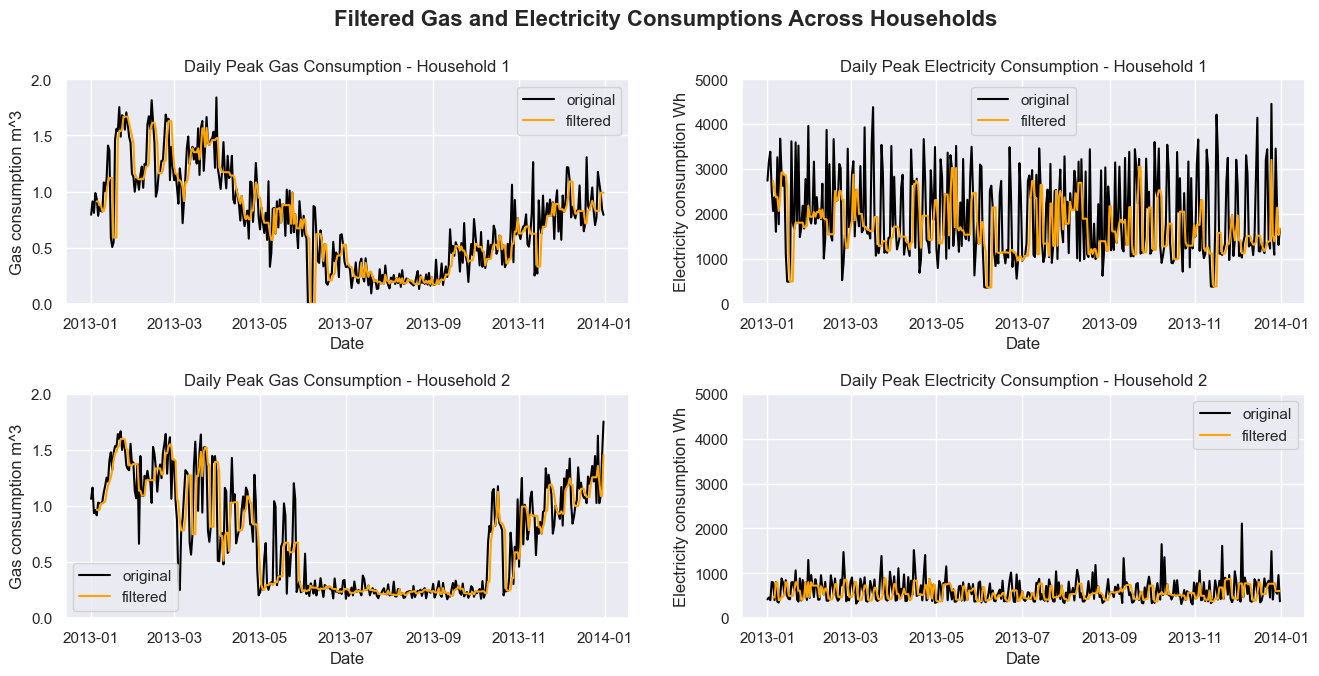

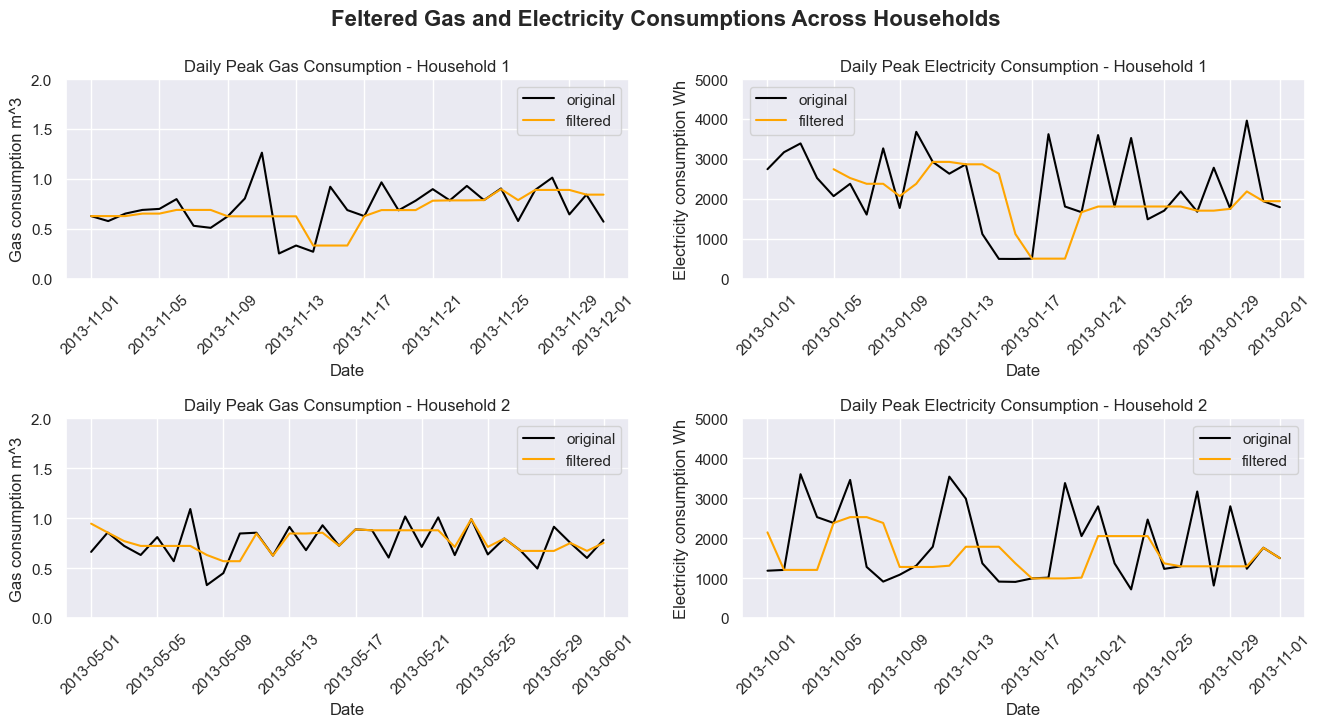

In [ ]:


df_daily_peak_household_1['gas_filtered'] = df_daily_peak_household_1['gas'].rolling(5).median()
df_daily_peak_household_2['gas_filtered'] = df_daily_peak_household_2['gas'].rolling(5).median()
df_daily_peak_household_1['electricity_filtered'] = df_daily_peak_household_1['electricity'].rolling(5).median()
df_daily_peak_household_2['electricity_filtered'] = df_daily_peak_household_2['electricity'].rolling(5).median()


fig, ax = plt.subplots(2, 2, figsize=(16,7))
ax[0, 0].plot(df_daily_peak_household_1.index, df_daily_peak_household_1['gas'], label='Gas Consumption (Household 1)', color='black')
ax[0, 0].plot(df_daily_peak_household_1.index, df_daily_peak_household_1['gas_filtered'], label='Filered Gas Consumption (Household 1)', color='orange')
ax[0, 0].set_title('Daily Peak Gas Consumption - Household 1')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Gas consumption m^3')
ax[0, 0].set_ylim(0, 2)
ax[0, 0].legend(['original', 'filtered'])

ax[1, 0].plot(df_daily_peak_household_2.index, df_daily_peak_household_2['gas'], label='Gas Consumption (Household 2)', color='black')
ax[1, 0].plot(df_daily_peak_household_2.index, df_daily_peak_household_2['gas_filtered'], label='Filered Gas Consumption (Household 1)', color='orange')
ax[1, 0].set_title('Daily Peak Gas Consumption - Household 2')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Gas consumption m^3')
ax[1, 0].set_ylim(0, 2)
ax[1, 0].legend(['original', 'filtered'])

ax[0, 1].plot(df_daily_peak_household_1.index, df_daily_peak_household_1['electricity'], label='Electricity Consumption (Household 1)', color='black')
ax[0, 1].plot(df_daily_peak_household_1.index, df_daily_peak_household_1['electricity_filtered'], label='Filered Electricity Consumption (Household 1)', color='orange')
ax[0, 1].set_title('Daily Peak Electricity Consumption - Household 1')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Electricity consumption Wh')
ax[0, 1].set_ylim(0, 5000)
ax[0, 1].legend(['original', 'filtered'])

ax[1, 1].plot(df_daily_peak_household_2.index, df_daily_peak_household_2['electricity'], label='Electricity Consumption (Household 1)', color='black')
ax[1, 1].plot(df_daily_peak_household_2.index, df_daily_peak_household_2['electricity_filtered'], label='Filered Electricity Consumption (Household 1)', color='orange')
ax[1, 1].set_title('Daily Peak Electricity Consumption - Household 2')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Electricity consumption Wh')
ax[1, 1].set_ylim(0, 5000)
ax[1, 1].legend(['original', 'filtered'])

plt.suptitle('Filtered Gas and Electricity Consumptions Across Households', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.2)



df_zoomed_1_gas = df_daily_peak_household_1.loc['2013-11-01':'2013-12-01']
df_zoomed_2_gas = df_daily_peak_household_1.loc['2013-05-01':'2013-06-01']
df_zoomed_1_electricity = df_daily_peak_household_1.loc['2013-01-01':'2013-02-01']
df_zoomed_2_electricity = df_daily_peak_household_1.loc['2013-10-01':'2013-11-01']

fig, ax = plt.subplots(2, 2, figsize=(16,7))
ax[0, 0].plot(df_zoomed_1_gas.index, df_zoomed_1_gas['gas'], label='Gas Consumption (Household 1)', color='black')
ax[0, 0].plot(df_zoomed_1_gas.index, df_zoomed_1_gas['gas_filtered'], label='Filered Gas Consumption (Household 1)', color='orange')
ax[0, 0].set_title('Daily Peak Gas Consumption - Household 1')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Gas consumption m^3')
ax[0, 0].set_ylim(0, 2)
ax[0, 0].legend(['original', 'filtered'])
ax[0, 0].tick_params(axis='x', rotation=45)

ax[1, 0].plot(df_zoomed_2_gas.index, df_zoomed_2_gas['gas'], label='Gas Consumption (Household 2)', color='black')
ax[1, 0].plot(df_zoomed_2_gas.index, df_zoomed_2_gas['gas_filtered'], label='Filered Gas Consumption (Household 1)', color='orange')
ax[1, 0].set_title('Daily Peak Gas Consumption - Household 2')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Gas consumption m^3')
ax[1, 0].set_ylim(0, 2)
ax[1, 0].legend(['original', 'filtered'])
ax[1, 0].tick_params(axis='x', rotation=45)

ax[0, 1].plot(df_zoomed_1_electricity.index, df_zoomed_1_electricity['electricity'], label='Electricity Consumption (Household 1)', color='black')
ax[0, 1].plot(df_zoomed_1_electricity.index, df_zoomed_1_electricity['electricity_filtered'], label='Filered Electricity Consumption (Household 1)', color='orange')
ax[0, 1].set_title('Daily Peak Electricity Consumption - Household 1')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Electricity consumption Wh')
ax[0, 1].set_ylim(0, 5000)
ax[0, 1].legend(['original', 'filtered'])
ax[0, 1].tick_params(axis='x', rotation=45)

ax[1, 1].plot(df_zoomed_2_electricity.index, df_zoomed_2_electricity['electricity'], label='Electricity Consumption (Household 1)', color='black')
ax[1, 1].plot(df_zoomed_2_electricity.index, df_zoomed_2_electricity['electricity_filtered'], label='Filered Electricity Consumption (Household 1)', color='orange')
ax[1, 1].set_title('Daily Peak Electricity Consumption - Household 2')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Electricity consumption Wh')
ax[1, 1].set_ylim(0, 5000)
ax[1, 1].legend(['original', 'filtered'])
ax[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Feltered Gas and Electricity Consumptions Across Households', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.7, wspace=0.2)


In [ ]:


s_atypical_1 = pd.Series(index=df_household_1['date'].unique()).fillna(False)
s_atypical_1.loc['2013-01-15':'2013-01-19'] = True
s_atypical_1.loc['2013-03-08':'2013-03-11'] = True 
s_atypical_1.loc['2013-03-16':'2013-03-24'] = True 
s_atypical_1.loc['2013-05-25':'2013-05-29'] = True 
s_atypical_1.loc['2013-06-04':'2013-06-09'] = True 
s_atypical_1.loc['2013-06-15':'2013-06-30'] = True 
s_atypical_1.loc['2013-09-12':'2013-09-27'] = True
s_atypical_1.loc['2013-11-09':'2013-11-18'] = True 

s_atypical_2 = pd.Series(index=df_household_2['date'].unique()).fillna(False)
s_atypical_2.loc['2013-01-11':'2013-01-19'] = True 
s_atypical_2.loc['2013-03-12':'2013-03-16'] = True 
s_atypical_2.loc['2013-03-25':'2013-03-29'] = True 
s_atypical_2.loc['2013-04-22':'2013-04-24'] = True 
s_atypical_2.loc['2013-05-06':'2013-05-11'] = True
s_atypical_2.loc['2013-10-03':'2013-10-15'] = True 
s_atypical_2.loc['2013-10-19':'2013-10-23'] = True
s_atypical_2.loc['2013-12-24':'2013-12-26'] = True

atypical_reasons = """
    Faulty equipment can lead to excessive energy use, which is shown as extreme peaks on graphs.
    Extremely cold weather conditions prompt more heating or cooling, and vise versa.
    Holiday activities and special events cause increased consumption due to more cooking, lighting, and gathering. On the other hand, 
    during those periods, people can travel to other places, leading to reduced values of energy consumption.
    Atypical records can significantly influence further data analysis, so these readings should be withdrawn.
"""

# Hypothesis test

In [ ]:


df_household_1_2013 = df_household_1.copy()
df_household_2_2013 = df_household_2.copy()

df_household_1_2013 = df_household_1_2013[~df_household_1_2013['electricity'].isna()]
df_household_1_2013 = df_household_1_2013[np.isfinite(df_household_1_2013['electricity'])]
df_household_2_2013 = df_household_2_2013[~df_household_2_2013['electricity'].isna()]
df_household_2_2013 = df_household_2_2013[np.isfinite(df_household_2_2013['electricity'])]

from scipy.stats import ttest_ind

conn_customer = sqlite3.connect('GA2_files/data.db')

query_weather = """
    SELECT datetime, date, cloud_cover 
    FROM weather_extra
    WHERE date LIKE "2013%"
"""
df_weather_2013 = pd.read_sql_query(query_weather, conn_customer, index_col='datetime')
df_weather_1_2013 = df_weather_2013.copy()
df_weather_2_2013 = df_weather_2013.copy()

df_household_1_2013['date'] = pd.to_datetime(df_household_1_2013['date'])
df_household_2_2013['date'] = pd.to_datetime(df_household_2_2013['date'])
df_weather_1_2013['date'] = pd.to_datetime(df_weather_1_2013['date'])
df_weather_2_2013['date'] = pd.to_datetime(df_weather_2_2013['date'])

df_household_1_2013.index = pd.to_datetime(df_household_1_2013.index)
df_household_2_2013.index = pd.to_datetime(df_household_2_2013.index)
df_weather_1_2013.index = pd.to_datetime(df_weather_1_2013.index)
df_weather_2_2013.index = pd.to_datetime(df_weather_2_2013.index)


df_household_1_2013 = df_household_1_2013[~df_household_1_2013['date'].isin(s_atypical_1[s_atypical_1].index)]
df_household_2_2013 = df_household_2_2013[~df_household_2_2013['date'].isin(s_atypical_2[s_atypical_2].index)]
df_weather_1_2013 = df_weather_1_2013[~df_weather_1_2013['date'].isin(s_atypical_1[s_atypical_1].index)]
df_weather_2_2013 = df_weather_2_2013[~df_weather_2_2013['date'].isin(s_atypical_2[s_atypical_2].index)]


df_merged_1 = df_household_1_2013.merge(df_weather_1_2013, how='inner', left_index=True, right_index=True)
df_merged_2 = df_household_2_2013.merge(df_weather_2_2013, how='inner', left_index=True, right_index=True)


high_cloud_1 = df_merged_1[df_merged_1['cloud_cover'] >= 5]['electricity']
low_cloud_1 = df_merged_1[df_merged_1['cloud_cover'] < 5]['electricity']

high_cloud_2 = df_merged_2[df_merged_2['cloud_cover'] >= 5]['electricity']
low_cloud_2 = df_merged_2[df_merged_2['cloud_cover'] < 5]['electricity']

high_cloud_1 = high_cloud_1.dropna()
low_cloud_1 = low_cloud_1.dropna()
high_cloud_2 = high_cloud_2.dropna()
low_cloud_2 = low_cloud_2.dropna()


t_stat_1, p_value_1 = ttest_ind(high_cloud_1, low_cloud_1, equal_var=False)
t_stat_2, p_value_2 = ttest_ind(high_cloud_2, low_cloud_2, equal_var=False)


print(f"Household 1: t-statistic = {t_stat_1}, p-value = {p_value_1}")
print(f"Household 2: t-statistic = {t_stat_2}, p-value = {p_value_2}")

alpha = 0.05
if p_value_1 < alpha:
    print("For Household 1, reject the null hypothesis: there is a significant difference in electricity consumption.")
else:
    print("For Household 1, fail to reject the null hypothesis: No significant difference in electricity consumption.")
if p_value_2 < alpha:
    print("For Household 2, reject the null hypothesis: there is a significant difference in electricity consumption.")
else:
    print("For Household 2, fail to reject the null hypothesis: No significant difference in electricity consumption.")


Household 1: t-statistic = -2.3089204269170507, p-value = 0.02099823895736464
Household 2: t-statistic = -2.911477557788146, p-value = 0.0036145794477092613
For Household 1, reject the null hypothesis: there is a significant difference in electricity consumption.
For Household 2, reject the null hypothesis: there is a significant difference in electricity consumption.


---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2024-2025 - **TU/e** - Eindhoven University of Technology